<a href="https://colab.research.google.com/github/JanGorczynski/Sentiment_Analysis_project/blob/main/CudaProjekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner
!pip install nltk
!pip install scikit-learn
!pip install seaborn
!pip install gensim

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from keras.models import Sequential, Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import LSTM,CuDNNLSTM, Dropout, Embedding, Conv1D, MultiHeadAttention, Input, Flatten, BatchNormalization, Dropout
from kerastuner import RandomSearch, HyperModel

C:\Users\S7ST3M\AppData\Local\Temp\ipykernel_15892\2036113830.py:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch, HyperModel


# Data imports and preparation
In this section we loaded and prepared data for traning
Natural Langauge Toolkit
We want to get rid of the unimportant words like the, a, <br> and other like that (they does not matter in in classification wheteher it's positive or negative review)

In [3]:

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\S7ST3M\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\S7ST3M\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df = pd.read_csv("IMDB Dataset.csv")

In [5]:
df.columns = ["Review","Sentiment"]

In [6]:
df.head()

,Review,Sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     50000 non-null  object
 1   Sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
df["Sentiment"].value_counts()

Sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [9]:
test = df["Review"][3]
print(test)

Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.


Following fuction takes sentence and preparse it for traning by: <br>
1 Converting the word to lower case <br>
2 Removing html '< br />< br />' tag <br>
3 Removing non letter characters <br>
4 Removing stop words <br>
5 Lemmatizing words eg. gives -> give <br>

In [10]:
def prep_sentence(sentence):
  lemmatizer = WordNetLemmatizer()
  sentence = sentence.lower()
  sentence = sentence.replace("<br /><br />"," ")
  sentence = re.sub("\'", "",sentence)
  sentence = re.sub(r'[^a-z]', ' ', sentence)

  sentence = sentence.split()
  stop_words = set(stopwords.words('english'))
  for word in sentence:
    if word in stop_words:
      sentence.remove(word)
  for i in range(len(sentence)):
    sentence[i] = lemmatizer.lemmatize(sentence[i])

  return " ".join(sentence)

In [11]:
print(prep_sentence(test))

basically there family little boy jake think there zombie closet his parent fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first youre going make film must decide it thriller a drama a drama movie watchable parent divorcing arguing like real life then have jake his closet totally ruin all film expected see a boogeyman similar movie instead watched a drama some meaningless thriller spot of for the well playing parent descent dialog for the shot jake ignore


In [12]:
print(df["Review"].isnull().sum())
print(df["Sentiment"].isnull().sum())

0
0


In [13]:
df["Processed_review"] = df['Review'].apply(prep_sentence)

In [14]:
df["Processed_review"]

0        one reviewer mentioned after watching oz episo...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically there family little boy jake think t...
4        petter matteis love time money visually stunni...
                               ...                        
49995    thought movie right good job wasnt creative or...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    am catholic taught parochial elementary school...
49998    im going have disagree previous comment side m...
49999    one expects star trek movie be high art fan ex...
Name: Processed_review, Length: 50000, dtype: object

Since majority of reviews are between 0 and 250 words long, we decided to make word limit 250

<Axes: xlabel='Processed_review', ylabel='Count'>

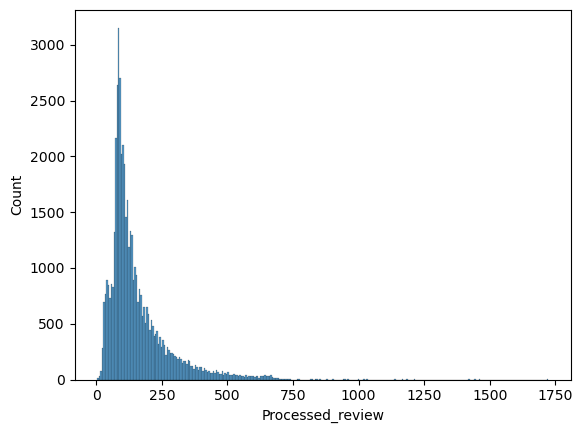

In [15]:
sns.histplot(df["Processed_review"].apply(lambda x: len(x.split())))

In [16]:
y_labels = []
for sentiment in df["Sentiment"]:
  if sentiment == "positive":
    y_labels.append(1)
  else:
    y_labels.append(0)

y_labels = np.array(y_labels)

for i in range(0,10):
  print(y_labels[i],df["Sentiment"][i])

1 positive
1 positive
1 positive
0 negative
1 positive
1 positive
1 positive
0 negative
0 negative
1 positive


In [17]:
maxwords = 10000
max_len = 250
x_data = list(df["Processed_review"])

In [18]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(x_data, y_labels, test_size=0.2, random_state=101)

In [19]:
tokenizer = Tokenizer(num_words=maxwords)
tokenizer.fit_on_texts(X_train_raw)
X_train = tokenizer.texts_to_sequences(X_train_raw)
X_test = tokenizer.texts_to_sequences(X_test_raw)
X_train = np.array(pad_sequences(X_train, maxlen=max_len))
X_test = np.array(pad_sequences(X_test, maxlen=max_len))

In [20]:
print(X_train.shape)
print(X_test.shape)

(40000, 250)
(10000, 250)


This functions will be needed in predictions analysis

In [21]:
def get_len(x):
  for i in range(len(x)):
    if(x[i]!=0):
      return len(x)-i
  return 0

In [22]:
def to_cat(i):
  if(i<0.5):
    return 0
  else:
    return 1

# CNN

A Convolutional Neural Network (CNN) is a type of artificial neural network designed specifically for processing and analyzing visual data, such as images and videos. CNNs are widely used in computer vision tasks like image classification, object detection, facial recognition, and more. They are inspired by the human visual system's ability to identify patterns and features in visual information.s.

In [44]:
def build(n):
    
  model = Sequential()
  model.add(Input(shape=(250,)))
  model.add(Embedding(maxwords,25))
  model.add(Conv1D(128, 5,padding = "same",activation = "relu"))
  model.add(Flatten())
  model.add(Dense(128,activation="relu"))
  model.add(Dense(64,activation="relu"))
  model.add(Dense(32,activation="relu"))
  model.add(Dense(16,activation = "relu"))
  model.add(Dense(1,activation = "sigmoid"))
  model.compile(optimizer=Adam(learning_rate=0.0001),loss="binary_crossentropy",metrics = "accuracy")
  return model

In [45]:
X_train_cnn = X_train.reshape(X_train.shape[0],X_train.shape[1],1).astype(float)
X_test_cnn = X_test.reshape(X_test.shape[0],X_test.shape[1],1).astype(float)
y_train_cnn = y_train.reshape(y_train.shape[0],1).astype(float)
y_test_cnn = y_test.reshape(y_test.shape[0],1).astype(float)




In [46]:
model_cnn = build(3)

In [47]:
model_cnn.fit(X_train_cnn,y_train_cnn,batch_size=256,epochs=15,validation_data=(X_test_cnn,y_test_cnn))

Epoch 1/15
157/157 [==============================] - 7s 42ms/step - loss: 0.6879 - accuracy: 0.5459 - val_loss: 0.6463 - val_accuracy: 0.7208
Epoch 2/15
157/157 [==============================] - 3s 19ms/step - loss: 0.3893 - accuracy: 0.8380 - val_loss: 0.3004 - val_accuracy: 0.8732
Epoch 3/15
157/157 [==============================] - 3s 21ms/step - loss: 0.2445 - accuracy: 0.9005 - val_loss: 0.2753 - val_accuracy: 0.8854
Epoch 4/15
157/157 [==============================] - 3s 20ms/step - loss: 0.2035 - accuracy: 0.9213 - val_loss: 0.2678 - val_accuracy: 0.8904
Epoch 5/15
157/157 [==============================] - 3s 21ms/step - loss: 0.1767 - accuracy: 0.9334 - val_loss: 0.2736 - val_accuracy: 0.8914
Epoch 6/15
157/157 [==============================] - 3s 20ms/step - loss: 0.1548 - accuracy: 0.9435 - val_loss: 0.2836 - val_accuracy: 0.8875
Epoch 7/15
157/157 [==============================] - 4s 22ms/step - loss: 0.1360 - accuracy: 0.9514 - val_loss: 0.2944 - val_accuracy: 0.8895

In [48]:
predictions =  model_cnn.predict(X_test)

313/313 [==============================] - 2s 3ms/step


In [49]:
predictions = [ to_cat(i) for i in predictions]

In [50]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      4959
           1       0.87      0.88      0.88      5041

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [51]:
print(pd.DataFrame(confusion_matrix(y_test,predictions),columns = ["Positive values", "Negative values"],
                   index = ["Positive guesses", "Negative guesses"]))

                  Positive values  Negative values
Positive guesses             4318              641
Negative guesses              604             4437


In [52]:
X_test[3]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [53]:
df = pd.DataFrame(predictions, columns = ["pred"])
df["true_val"] = y_test
df["is_true"] = (df["true_val"] == df["pred"])
df["len"] = pd.Series([get_len(i) for i in X_test])

<Axes: xlabel='len', ylabel='Count'>

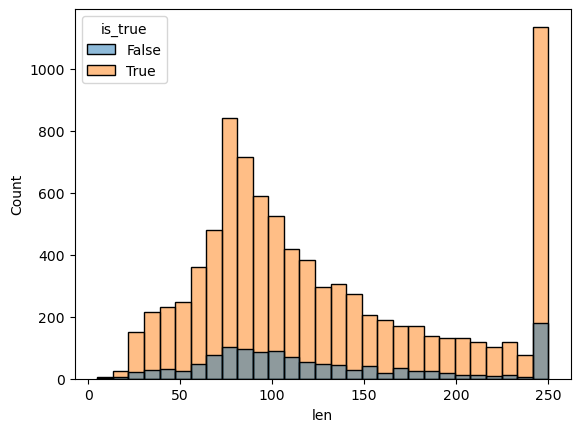

In [54]:
sns.histplot(data = df, x = "len",hue = "is_true")

In [56]:
def isReviewPositive(text):
    text = prep_sentence(text)
   
    tokenizer.fit_on_texts([text])
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    predictions2 = model_cnn.predict(padded_sequences)
    print("raw: ", predictions2[0])
    if to_cat(predictions2[0]) == 0:
        print("Negative review")
        return False
    else:
        print("Positive review")
        return True
    

In [58]:
print("\nType in review: ")
inputIn = input()
while inputIn != ":q":
    
    isReviewPositive(inputIn)
    
    print("\nType in review: ")
    inputIn = input()



Type in review: 


 this movie was terrific


1/1 [==============================] - 0s 16ms/step
raw:  [0.92179275]
Positive review

Type in review: 


 this movie was bad


1/1 [==============================] - 0s 16ms/step
raw:  [0.38160467]
Negative review

Type in review: 


 this movie was tragic


1/1 [==============================] - 0s 16ms/step
raw:  [0.3642126]
Negative review

Type in review: 


 :q


In [59]:
textIn = "The movie was terrible. The acting was wooden, the plot was predictable, and the special effects were laughable. Save your money and avoid it at all costs."
isReviewPositive(textIn)

1/1 [==============================] - 0s 17ms/step
raw:  [0.01064418]
Negative review


False